# カテゴリ変数の分析

In [17]:
import pandas as pd
import japanize_matplotlib
import importlib
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import pipe
import lightgbm as lgb
from sklearn.model_selection import train_test_split, cross_val_score


importlib.reload(pipe)
from pipe.baseline import Baseline


pd.options.display.max_columns = None

In [18]:
df_train = pd.read_csv("../data/train.csv")

df_train.describe()

,id,Age,DailyRate,DistanceFromHome,Education,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,JobSatisfaction,MonthlyIncome,NumCompaniesWorked,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,Attrition
count,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.00000,1200.000000,1200.0,1200.000000,1200.000000,1200.000000,1200.00000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000
mean,1013.075833,32.701667,750.754157,10.218387,2.853333,2.655833,66.261667,2.716667,2.125833,2.717500,7052.521667,2.614167,15.115000,3.11000,2.616667,80.0,0.863333,10.631667,2.755000,2.70000,6.351667,4.249167,2.163333,3.780000,0.177500
std,575.726036,8.282199,415.420917,8.134144,1.060390,1.139502,20.257801,0.675847,1.185821,1.091797,5033.677026,2.460422,3.632415,0.31302,1.066460,0.0,0.874810,7.721335,1.256167,0.70267,5.120532,3.688507,3.312219,3.314225,0.382251
min,0.000000,17.000000,59.231581,-0.023999,1.000000,1.000000,30.000000,1.000000,1.000000,1.000000,1052.000000,0.000000,11.000000,3.00000,1.000000,80.0,0.000000,0.000000,0.000000,1.00000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,508.750000,26.000000,403.946043,2.688173,2.000000,2.000000,48.000000,2.000000,1.000000,2.000000,3537.000000,1.000000,12.000000,3.00000,2.000000,80.0,0.000000,5.000000,2.000000,2.00000,2.000000,2.000000,0.000000,2.000000,0.000000
50%,1018.000000,34.000000,736.873463,9.345924,3.000000,3.000000,67.000000,3.000000,2.000000,3.000000,5071.000000,1.000000,14.000000,3.00000,3.000000,80.0,1.000000,9.000000,3.000000,3.00000,5.000000,3.000000,1.000000,3.000000,0.000000
75%,1519.250000,37.000000,1092.443495,15.231438,4.000000,4.000000,84.000000,3.000000,3.000000,4.000000,8715.250000,4.000000,18.000000,3.00000,3.250000,80.0,1.000000,15.000000,3.000000,3.00000,9.000000,7.000000,2.000000,7.000000,0.000000
max,1998.000000,56.000000,1484.979305,29.890208,5.000000,4.000000,100.000000,4.000000,5.000000,4.000000,19833.000000,9.000000,25.000000,4.00000,4.000000,80.0,3.000000,36.000000,6.000000,4.00000,32.000000,17.000000,15.000000,17.000000,1.000000


### YearsWithCurrentManagerの詳細をみて、ロジスティック分布を作る

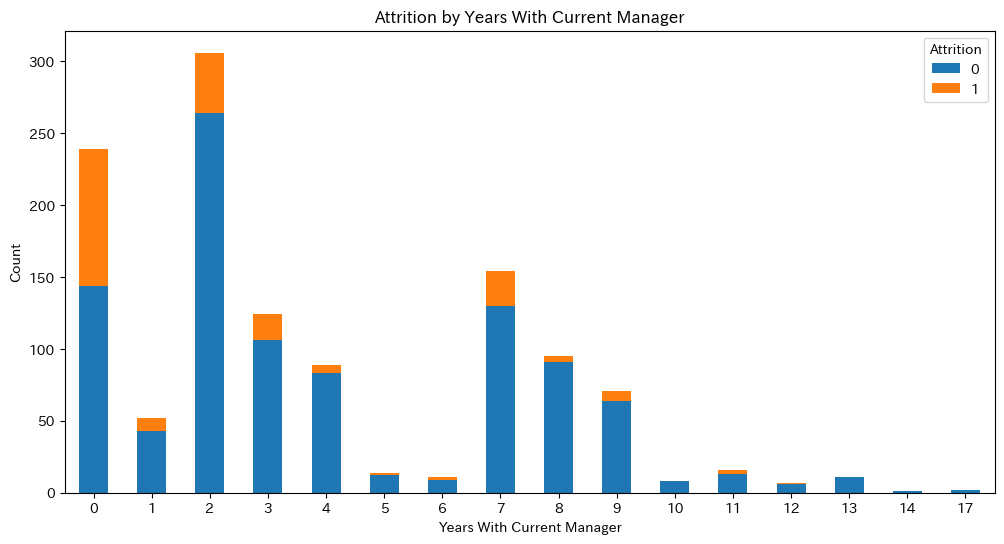

In [19]:
df_train_copy = df_train.copy()

# YearsWithCurrentManagerとAttritionの関係を集計
attrition_by_years = (
    df_train_copy.groupby("YearsWithCurrManager")["Attrition"]
    .value_counts()
    .unstack()
    .fillna(0)
)

# 棒グラフを描く
attrition_by_years.plot(kind="bar", stacked=True, figsize=(12, 6))
plt.xlabel("Years With Current Manager")
plt.ylabel("Count")
plt.title("Attrition by Years With Current Manager")
plt.xticks(rotation=0)  # x軸のラベルを回転しない
plt.legend(title="Attrition")
plt.show()

/var/folders/1w/52jfb36j6sg557p8z_gknglh0000gn/T/ipykernel_77285/3694503375.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df_train_copy.groupby("YearsGroup")["Attrition"].mean().reset_index()


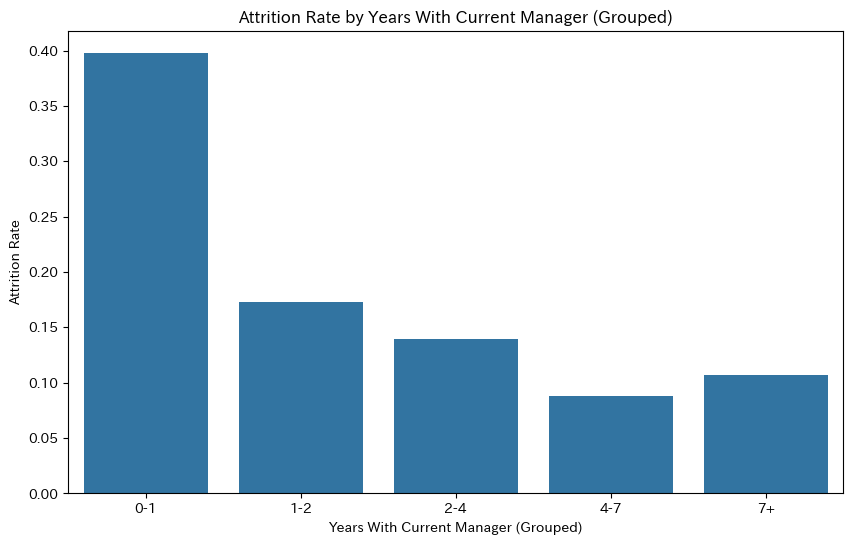

In [20]:
# YearsWithCurrManagerとAttritionの関係をグループ分けして観察
bins = [0, 1, 2, 4, 7, df_train_copy["YearsWithCurrManager"].max()]
labels = ["0-1", "1-2", "2-4", "4-7", "7+"]
df_train_copy["YearsGroup"] = pd.cut(
    df_train_copy["YearsWithCurrManager"], bins=bins, labels=labels, right=False
)

# グループごとの離職率を計算
grouped = df_train_copy.groupby("YearsGroup")["Attrition"].mean().reset_index()

# グラフを描く
plt.figure(figsize=(10, 6))
sns.barplot(x="YearsGroup", y="Attrition", data=grouped)
plt.xlabel("Years With Current Manager (Grouped)")
plt.ylabel("Attrition Rate")
plt.title("Attrition Rate by Years With Current Manager (Grouped)")
plt.show()

### 一応ぶっ込んでみる（精度下がった）

In [21]:
# bl = Baseline(train_file_path="../data/train.csv")

# bl.add_feature(feature=df_train_copy["YearsGroup"])

# impls, scores = bl.run()

# print(scores)
# print(impls)

### 性別と結婚離職の関係を見てみる

Gender_MaritalStatus
Female_Divorced    0.077778
Female_Married     0.156627
Female_Single      0.263514
Male_Divorced      0.109827
Male_Married       0.164134
Male_Single        0.260664
Name: Attrition, dtype: float64


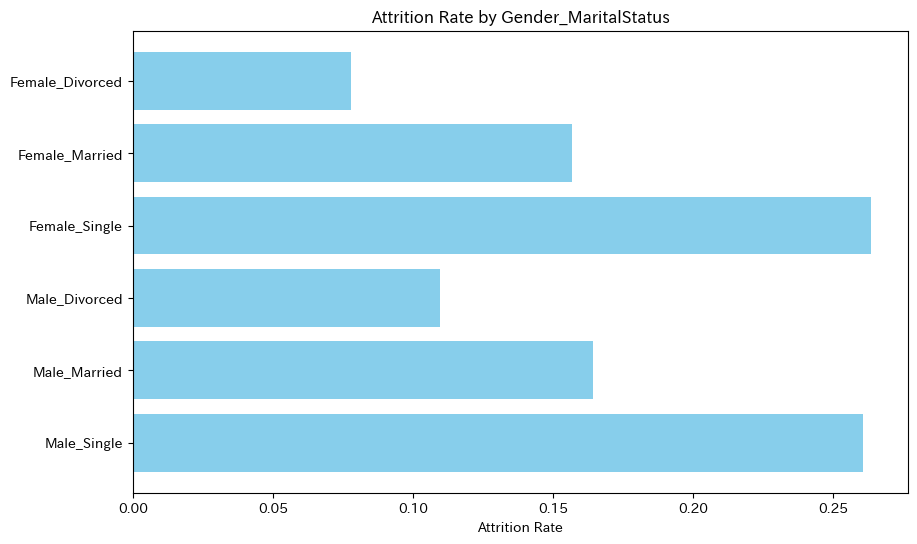

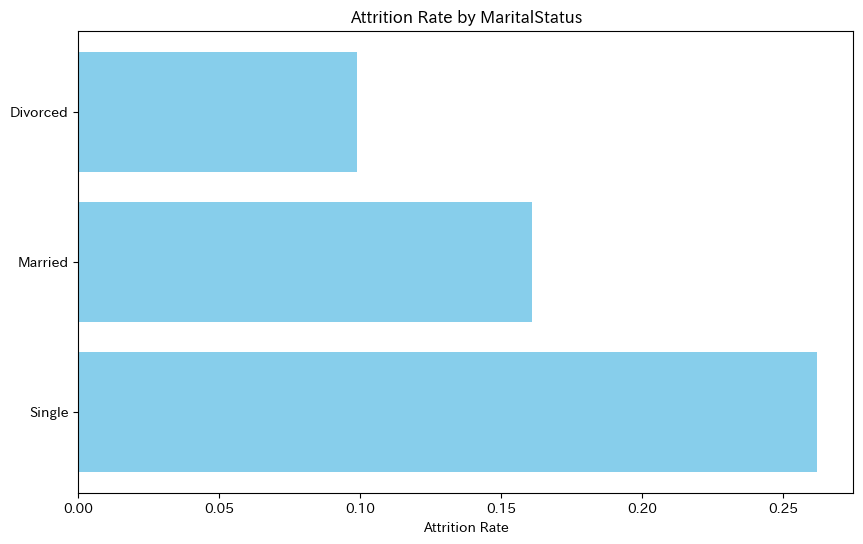

In [22]:
df_train_copy["Gender_MaritalStatus"] = (
    df_train_copy["Gender"] + "_" + df_train_copy["MaritalStatus"]
)

# プロット用のデータを作成
grouped = df_train_copy.groupby("Gender_MaritalStatus")["Attrition"].mean()
labels = grouped.index
values = grouped.values

print(grouped)
# グラフを描画
plt.figure(figsize=(10, 6))
plt.barh(labels, values, color="skyblue")
plt.xlabel("Attrition Rate")
plt.title("Attrition Rate by Gender_MaritalStatus")
plt.gca().invert_yaxis()  # グラフを反転させて長いバーが上にくるようにする
plt.show()

grouped = df_train_copy.groupby("MaritalStatus")["Attrition"].mean()
labels = grouped.index
values = grouped.values

# グラフを描画
plt.figure(figsize=(10, 6))
plt.barh(labels, values, color="skyblue")
plt.xlabel("Attrition Rate")
plt.title("Attrition Rate by MaritalStatus")
plt.gca().invert_yaxis()
plt.show()

## OverTimeによる精度向上

In [23]:
df_train_copy_dummy = pd.get_dummies(df_train_copy, columns=["OverTime"])

df_train_copy_dummy.head()

,id,Age,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EnvironmentSatisfaction,Gender,HourlyRate,JobInvolvement,JobLevel,JobRole,JobSatisfaction,MaritalStatus,MonthlyIncome,NumCompaniesWorked,Over18,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,Attrition,YearsGroup,Gender_MaritalStatus,OverTime_No,OverTime_Yes
0,0,26,Travel_Rarely,450.941476,Research & Development,7.601074,3,Medical,4,Male,43,2,1,Laboratory Technician,2,Single,16307,1,Y,13,3,3,80,0,1,3,2,11,8,7,0,0,0-1,Male_Single,True,False
1,3,47,Travel_Rarely,730.235896,Research & Development,26.739489,3,Technical Degree,2,Male,98,2,1,Research Scientist,1,Divorced,9526,8,Y,11,3,3,80,1,20,1,1,5,9,4,4,0,4-7,Male_Divorced,False,True
2,7,26,Travel_Rarely,1082.560066,Human Resources,7.374739,3,Life Sciences,2,Male,84,2,1,Human Resources,2,Married,10596,8,Y,18,3,2,80,1,4,3,3,3,2,0,2,0,2-4,Male_Married,True,False
3,10,46,Travel_Rarely,706.247579,Research & Development,14.791373,1,Medical,1,Female,79,2,1,Laboratory Technician,3,Divorced,5762,0,Y,20,4,4,80,1,6,0,1,5,4,7,7,1,7+,Female_Divorced,False,True
4,11,25,Travel_Rarely,500.610860,Research & Development,2.146966,4,Medical,2,Male,98,3,2,Manufacturing Director,3,Divorced,17068,6,Y,14,3,2,80,1,8,3,3,1,0,0,0,0,0-1,Male_Divorced,False,True


In [24]:
bl = Baseline(train_file_path="../data/train.csv")


impls, scores = bl.run()

print(scores)
print(impls)

[LightGBM] [Info] Number of positive: 171, number of negative: 789
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000208 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 36
[LightGBM] [Info] Number of data points in the train set: 960, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.178125 -> initscore=-1.529103
[LightGBM] [Info] Start training from score -1.529103
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

# 勤務年数と職種の組み合わせによる離職の傾向があるのでは

In [25]:
bins = [0, 1, 2, 3, 4, 5, 6, 7, df_train_copy["YearsAtCompany"].max()]
labels = ["0-1", "1-2", "2-3", "3-4", "4-5", "5-6", "6-7", "9+"]
df_train_copy["YearsAtCompanyGroup"] = pd.cut(
    df_train_copy["YearsAtCompany"], bins=bins, labels=labels, right=False
)

df_train_copy["JobRole_YearsAtCompany"] = (
    df_train_copy["JobRole"] + "_" + df_train_copy["YearsAtCompanyGroup"].astype(str)
)


df_train_copy.head()

,id,Age,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EnvironmentSatisfaction,Gender,HourlyRate,JobInvolvement,JobLevel,JobRole,JobSatisfaction,MaritalStatus,MonthlyIncome,NumCompaniesWorked,Over18,OverTime,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,Attrition,YearsGroup,Gender_MaritalStatus,YearsAtCompanyGroup,JobRole_YearsAtCompany
0,0,26,Travel_Rarely,450.941476,Research & Development,7.601074,3,Medical,4,Male,43,2,1,Laboratory Technician,2,Single,16307,1,Y,No,13,3,3,80,0,1,3,2,11,8,7,0,0,0-1,Male_Single,9+,Laboratory Technician_9+
1,3,47,Travel_Rarely,730.235896,Research & Development,26.739489,3,Technical Degree,2,Male,98,2,1,Research Scientist,1,Divorced,9526,8,Y,Yes,11,3,3,80,1,20,1,1,5,9,4,4,0,4-7,Male_Divorced,5-6,Research Scientist_5-6
2,7,26,Travel_Rarely,1082.560066,Human Resources,7.374739,3,Life Sciences,2,Male,84,2,1,Human Resources,2,Married,10596,8,Y,No,18,3,2,80,1,4,3,3,3,2,0,2,0,2-4,Male_Married,3-4,Human Resources_3-4
3,10,46,Travel_Rarely,706.247579,Research & Development,14.791373,1,Medical,1,Female,79,2,1,Laboratory Technician,3,Divorced,5762,0,Y,Yes,20,4,4,80,1,6,0,1,5,4,7,7,1,7+,Female_Divorced,5-6,Laboratory Technician_5-6
4,11,25,Travel_Rarely,500.610860,Research & Development,2.146966,4,Medical,2,Male,98,3,2,Manufacturing Director,3,Divorced,17068,6,Y,Yes,14,3,2,80,1,8,3,3,1,0,0,0,0,0-1,Male_Divorced,1-2,Manufacturing Director_1-2


/var/folders/1w/52jfb36j6sg557p8z_gknglh0000gn/T/ipykernel_77285/1325244011.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = role_df.groupby("YearsAtCompanyGroup")["Attrition"].mean()


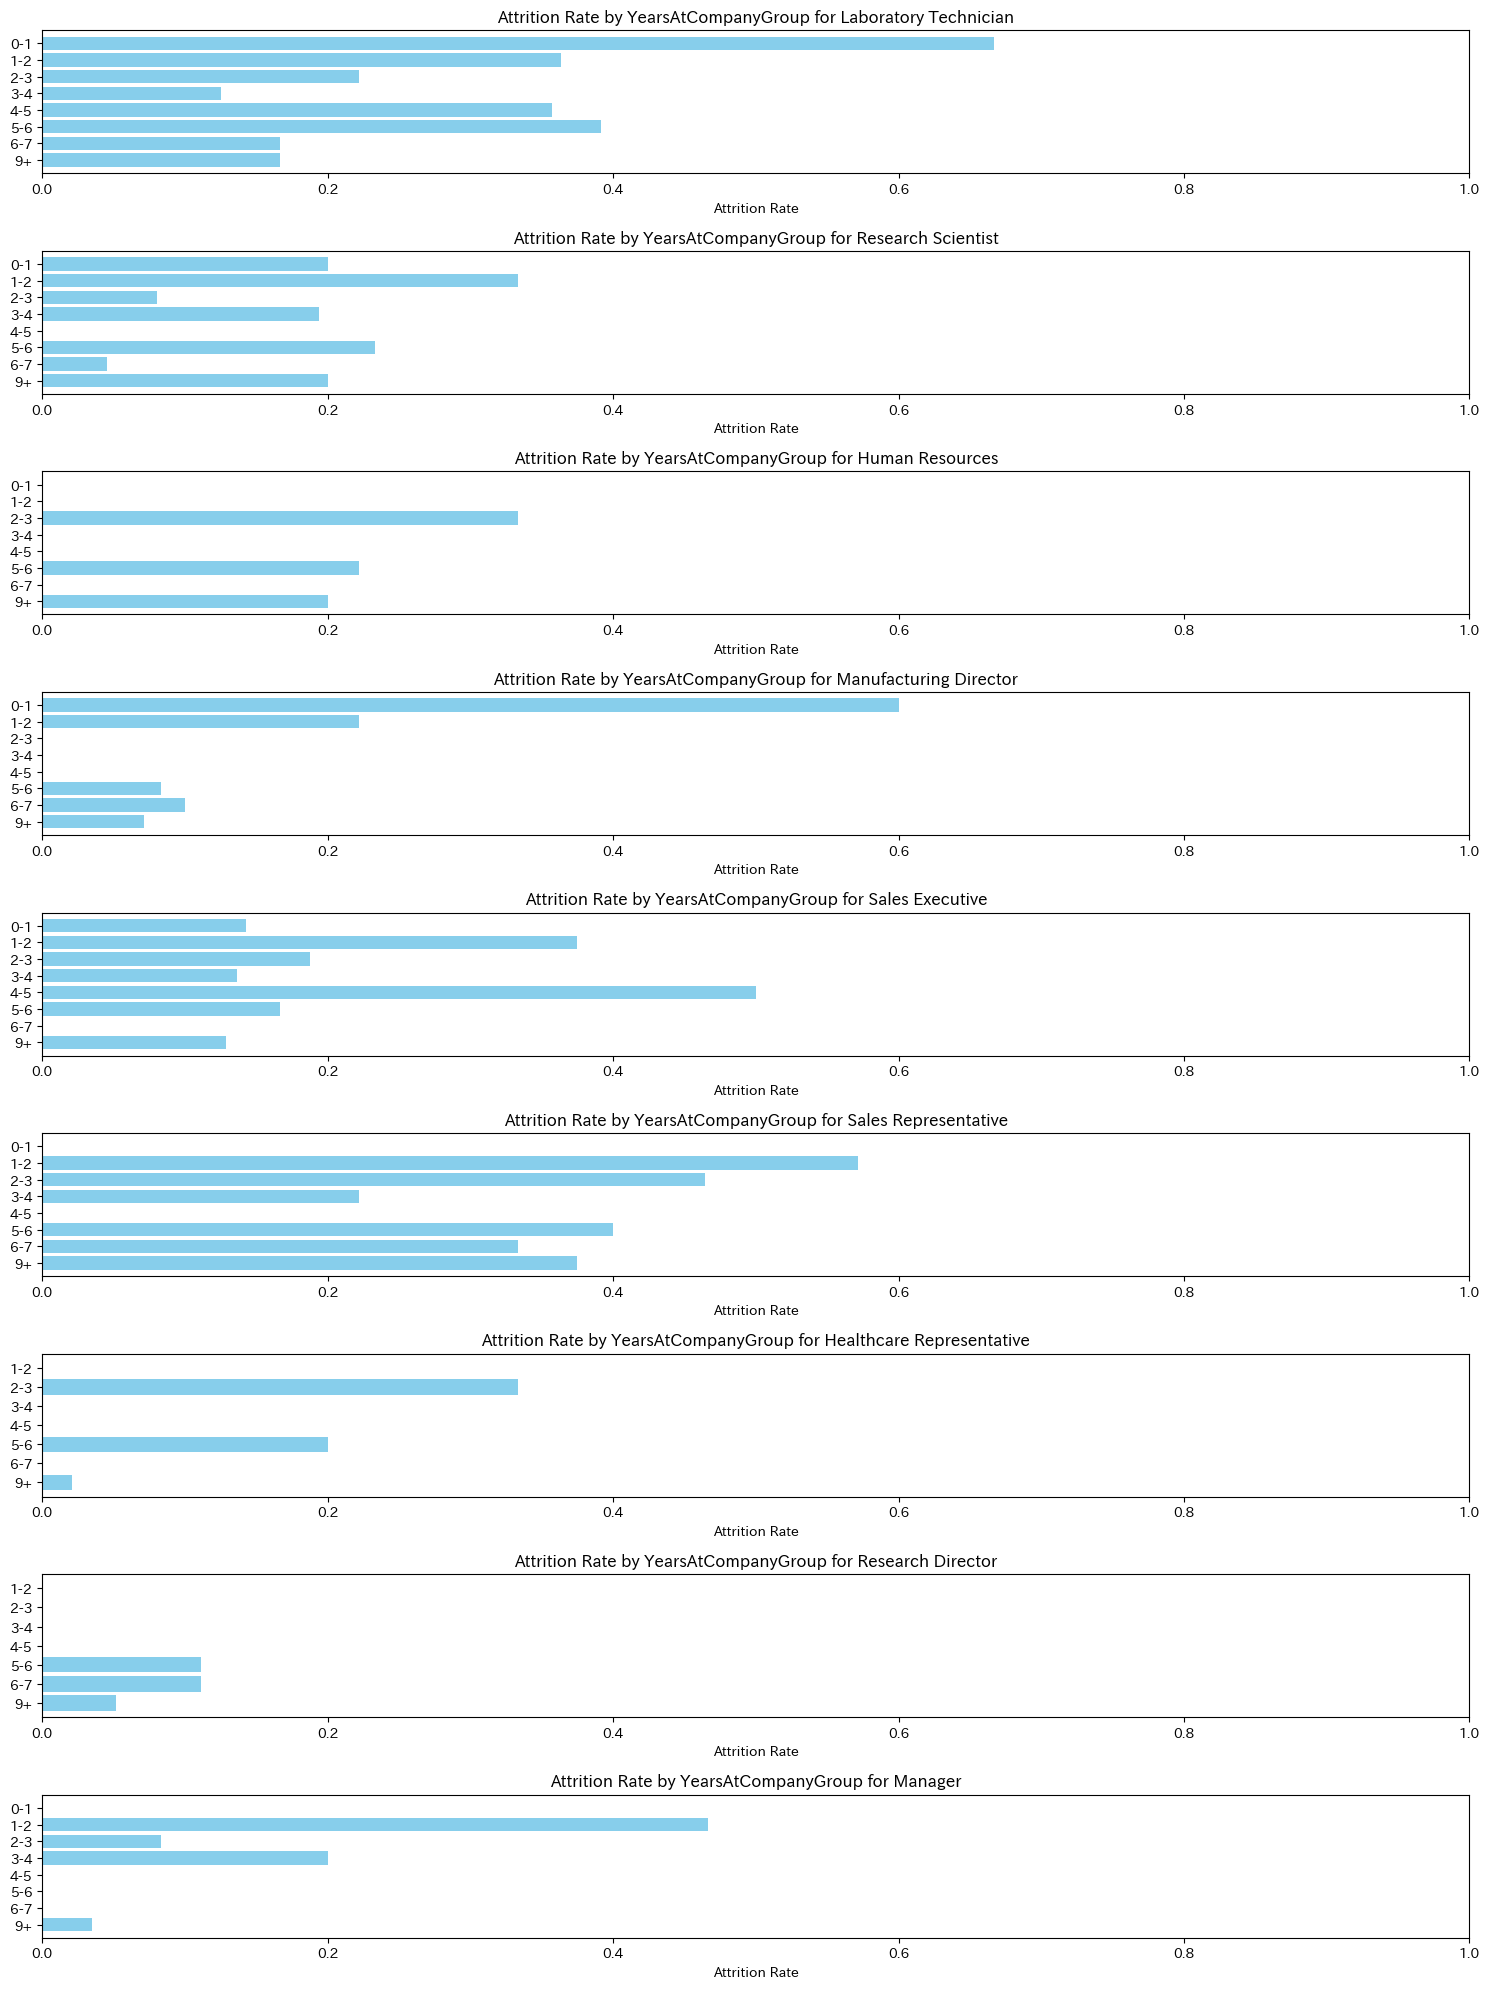

In [26]:
# 各JobRoleごとにAttrition率を計算しプロット
unique_job_roles = df_train_copy["JobRole"].unique()

plt.figure(figsize=(15, 20))
for i, job_role in enumerate(unique_job_roles, 1):
    plt.subplot(len(unique_job_roles), 1, i)
    role_df = df_train_copy[df_train_copy["JobRole"] == job_role]
    grouped = role_df.groupby("YearsAtCompanyGroup")["Attrition"].mean()
    labels = grouped.index
    values = grouped.values

    plt.barh(labels, values, color="skyblue")
    plt.xlim(0, 1)
    plt.xlabel("Attrition Rate")
    plt.title(f"Attrition Rate by YearsAtCompanyGroup for {job_role}")
    plt.gca().invert_yaxis()

plt.tight_layout()
plt.show()

In [27]:
df_train_copy["JobRole_YearsAtCompany_Count"] = df_train_copy[
    "JobRole_YearsAtCompany"
].map(df_train_copy["JobRole_YearsAtCompany"].value_counts())

df_train_copy.head()

,id,Age,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EnvironmentSatisfaction,Gender,HourlyRate,JobInvolvement,JobLevel,JobRole,JobSatisfaction,MaritalStatus,MonthlyIncome,NumCompaniesWorked,Over18,OverTime,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,Attrition,YearsGroup,Gender_MaritalStatus,YearsAtCompanyGroup,JobRole_YearsAtCompany,JobRole_YearsAtCompany_Count
0,0,26,Travel_Rarely,450.941476,Research & Development,7.601074,3,Medical,4,Male,43,2,1,Laboratory Technician,2,Single,16307,1,Y,No,13,3,3,80,0,1,3,2,11,8,7,0,0,0-1,Male_Single,9+,Laboratory Technician_9+,66
1,3,47,Travel_Rarely,730.235896,Research & Development,26.739489,3,Technical Degree,2,Male,98,2,1,Research Scientist,1,Divorced,9526,8,Y,Yes,11,3,3,80,1,20,1,1,5,9,4,4,0,4-7,Male_Divorced,5-6,Research Scientist_5-6,60
2,7,26,Travel_Rarely,1082.560066,Human Resources,7.374739,3,Life Sciences,2,Male,84,2,1,Human Resources,2,Married,10596,8,Y,No,18,3,2,80,1,4,3,3,3,2,0,2,0,2-4,Male_Married,3-4,Human Resources_3-4,5
3,10,46,Travel_Rarely,706.247579,Research & Development,14.791373,1,Medical,1,Female,79,2,1,Laboratory Technician,3,Divorced,5762,0,Y,Yes,20,4,4,80,1,6,0,1,5,4,7,7,1,7+,Female_Divorced,5-6,Laboratory Technician_5-6,23
4,11,25,Travel_Rarely,500.610860,Research & Development,2.146966,4,Medical,2,Male,98,3,2,Manufacturing Director,3,Divorced,17068,6,Y,Yes,14,3,2,80,1,8,3,3,1,0,0,0,0,0-1,Male_Divorced,1-2,Manufacturing Director_1-2,9


### 転職したことがあるかないかで離職するかが分かれる（検証中）

In [28]:
df_train_dummy_business_travel = pd.get_dummies(
    df_train_copy, columns=["BusinessTravel"]
)

df_train_dummy_business_travel

,id,Age,DailyRate,Department,DistanceFromHome,Education,EducationField,EnvironmentSatisfaction,Gender,HourlyRate,JobInvolvement,JobLevel,JobRole,JobSatisfaction,MaritalStatus,MonthlyIncome,NumCompaniesWorked,Over18,OverTime,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,Attrition,YearsGroup,Gender_MaritalStatus,YearsAtCompanyGroup,JobRole_YearsAtCompany,JobRole_YearsAtCompany_Count,BusinessTravel_Non-Travel,BusinessTravel_Travel_Frequently,BusinessTravel_Travel_Rarely
0,0,26,450.941476,Research & Development,7.601074,3,Medical,4,Male,43,2,1,Laboratory Technician,2,Single,16307,1,Y,No,13,3,3,80,0,1,3,2,11,8,7,0,0,0-1,Male_Single,9+,Laboratory Technician_9+,66,False,False,True
1,3,47,730.235896,Research & Development,26.739489,3,Technical Degree,2,Male,98,2,1,Research Scientist,1,Divorced,9526,8,Y,Yes,11,3,3,80,1,20,1,1,5,9,4,4,0,4-7,Male_Divorced,5-6,Research Scientist_5-6,60,False,False,True
2,7,26,1082.560066,Human Resources,7.374739,3,Life Sciences,2,Male,84,2,1,Human Resources,2,Married,10596,8,Y,No,18,3,2,80,1,4,3,3,3,2,0,2,0,2-4,Male_Married,3-4,Human Resources_3-4,5,False,False,True
3,10,46,706.247579,Research & Development,14.791373,1,Medical,1,Female,79,2,1,Laboratory Technician,3,Divorced,5762,0,Y,Yes,20,4,4,80,1,6,0,1,5,4,7,7,1,7+,Female_Divorced,5-6,Laboratory Technician_5-6,23,False,False,True
4,11,25,500.610860,Research & Development,2.146966,4,Medical,2,Male,98,3,2,Manufacturing Director,3,Divorced,17068,6,Y,Yes,14,3,2,80,1,8,3,3,1,0,0,0,0,0-1,Male_Divorced,1-2,Manufacturing Director_1-2,9,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1195,1988,49,969.251891,Research & Development,13.243579,2,Medical,4,Male,67,3,5,Research Director,4,Married,5098,8,Y,No,18,3,2,80,0,33,3,2,3,2,1,2,0,2-4,Male_Married,3-4,Research Director_3-4,7,False,False,True
1196,1994,37,437.940367,Research & Development,2.339438,1,Other,4,Male,82,3,2,Manufacturing Director,4,Married,6434,1,Y,Yes,11,3,4,80,0,6,5,2,9,2,0,8,0,7+,Male_Married,9+,Manufacturing Director_9+,56,False,True,False
1197,1996,40,978.883360,Human Resources,10.214979,3,Life Sciences,3,Male,40,2,3,Healthcare Representative,3,Divorced,3339,1,Y,No,12,3,2,80,1,19,2,3,14,9,9,9,0,7+,Male_Divorced,9+,Healthcare Representative_9+,48,True,False,False
1198,1997,37,170.494984,Sales,2.639879,2,Marketing,1,Male,93,4,2,Sales Executive,4,Divorced,2011,0,Y,No,16,3,1,80,2,6,5,3,3,2,0,3,0,2-4,Male_Divorced,3-4,Sales Executive_3-4,22,False,True,False


In [29]:
bl = Baseline(train_file_path="../data/train.csv")

# bl.add_feature(feature=df_train_dummy_business_travel["Non-Travel"])

impls, scores = bl.run()


print(scores)
print(impls)

bl.make_submit(
    test_file_path="../data/test.csv", submit_file_path="../data/submit-hello.csv"
)

[LightGBM] [Info] Number of positive: 171, number of negative: 789
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000193 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 36
[LightGBM] [Info] Number of data points in the train set: 960, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.178125 -> initscore=-1.529103
[LightGBM] [Info] Start training from score -1.529103
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

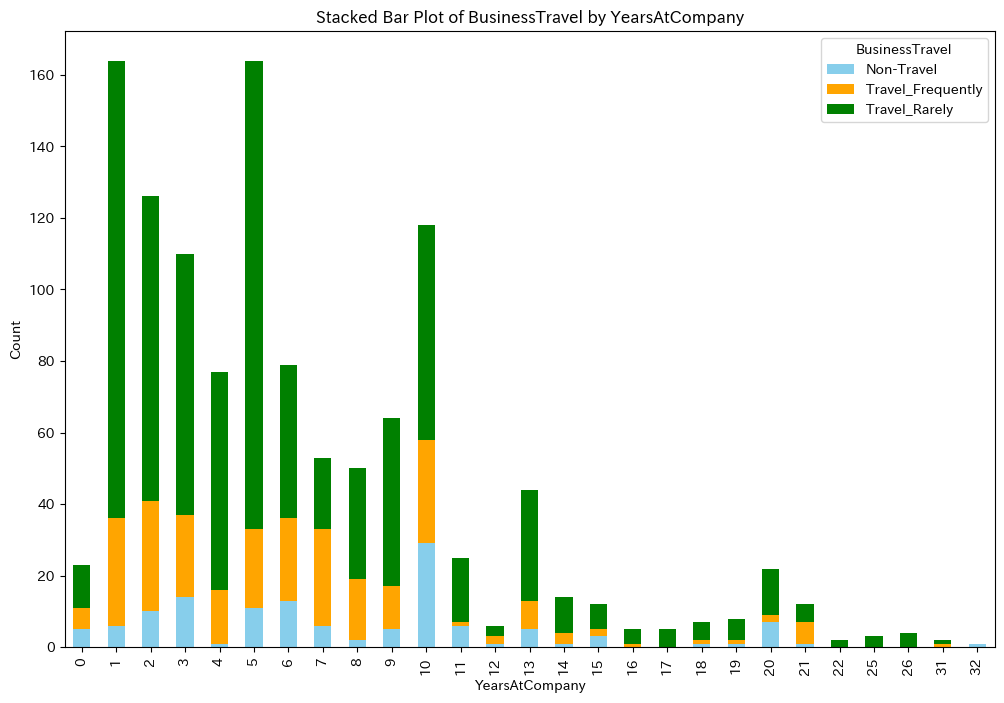

In [30]:
# 集計
grouped = (
    df_train.groupby(["YearsAtCompany", "BusinessTravel"]).size().unstack().fillna(0)
)

# 積み上げ棒グラフをプロット
grouped.plot(
    kind="bar", stacked=True, figsize=(12, 8), color=["skyblue", "orange", "green"]
)
plt.xlabel("YearsAtCompany")
plt.ylabel("Count")
plt.title("Stacked Bar Plot of BusinessTravel by YearsAtCompany")
plt.legend(title="BusinessTravel")
plt.show()

### DistanceFromHome

In [31]:
# # df_train_bin_distance = pd.cut(df_train["DistanceFromHome"], bins=5, labels=False)
# # 0.5 刻みのビン境界を設定
# # 0.5以下の値を持つ行があるため、最小値を切り上げる
# df_train['DistanceFromHome'] = df_train['DistanceFromHome'].clip(lower=0.5)
# min_distance = df_train['DistanceFromHome'].min()
# max_distance = df_train['DistanceFromHome'].max()

# bins = np.arange(min_distance, max_distance + 0.5, 0.5)

# # DistanceFromHome をビン分割
# df_train['DistanceFromHome'] = pd.cut(df_train['DistanceFromHome'], bins, labels=False)

# print(min_distance, max_distance)

In [32]:
bl = Baseline(
    train_file_path="../data/train.csv",
)

# bl.add_feature(feature=df_train["DistanceFromHome"])


impls, score = bl.run()

print(impls)
print(score)

bl.make_submit(
    test_file_path="../data/test.csv", submit_file_path="../data/submit-hello.csv"
)

[LightGBM] [Info] Number of positive: 171, number of negative: 789
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000278 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 36
[LightGBM] [Info] Number of data points in the train set: 960, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.178125 -> initscore=-1.529103
[LightGBM] [Info] Start training from score -1.529103
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[